# Quantum State Vector Simulator

This notebook presents a quantum circuit simulation using two approaches.
The simulation involves initializing quantum states, applying quantum gates (Hadamard, Pauli-X, and CNOT),
and measuring the performance in terms of runtime as the number of qubits increases. This approach leverages tensor multiplications to simulate the action of quantum gates on a quantum state.

---

## Overview
There are two approaches we are using to simualte the statevector.
1. **Naive Matrix Multiplication**
2. **Advanced Tensor Multiplication**

The code for each approach is structured into several main sections:
1. **Quantum State Initialization** - We create an initial quantum state (tensor) representing the |0⟩ state for all qubits.
2. **Defining Quantum Gates** - We define the Hadamard, Pauli-X, and CNOT gates as matrices.
3. **Applying Single and Two-Qubit Gates** - We implement tensor-based functions to apply gates on specific qubits.
4. **Circuit Simulation** - We simulate a quantum circuit by initializing a state, applying gates, and returning the final state.
5. **Performance Measurement** - We measure the simulation runtime as a function of the number of qubits.



# Naive Simulation Using Matrix Multiplication

In this approach, we represent quantum states as vectors and gates as matrices. By sequentially applying matrix multiplications, we can evolve the quantum state based on the gates in the circuit.

### Key Concepts
- **Qubit State**: In quantum computing, a qubit can exist in a state represented by a two-dimensional vector. The |0⟩ and |1⟩ states are represented as [1, 0] and [0, 1] respectively.
- **Quantum Gates**: Gates like X (NOT gate), H (Hadamard), and CNOT are represented by specific matrices. Applying a gate to a qubit is equivalent to matrix-vector multiplication.

### Objective
1. Define basic quantum gates using matrix representations.
2. Build a function to apply these gates to an initial state using matrix multiplication.
3. Measure the runtime for different numbers of qubits to analyze performance.




In [18]:
import numpy as np
import time
import matplotlib.pyplot as plt

def initialize_state(n_qubits):
    # Start with single |0> state
    state = np.array([1, 0], dtype=complex)
    for _ in range(n_qubits - 1):
        state = np.kron(state, [1, 0])
    return state


#Defining Quantum Gates

Below, we define the fundamental gates we’ll use in the circuit:
- **X Gate (NOT)**: Flips the state of the qubit.
- **H Gate (Hadamard)**: Creates superposition by transforming |0⟩ to (|0⟩ + |1⟩)/√2.
- **CNOT Gate**: Acts as a control gate, flipping the target qubit if the control qubit is |1⟩.

Each gate is represented by a 2x2 or 4x4 matrix, depending on whether it acts on one or two qubits.


In [19]:
# Single-qubit gates
I = np.array([[1, 0],
              [0, 1]], dtype=complex)

X = np.array([[0, 1],
              [1, 0]], dtype=complex)

H = (1 / np.sqrt(2)) * np.array([[1, 1],
                                 [1, -1]], dtype=complex)

# Two-qubit gate
def cnot_gate(control, target, n_qubits):
    # Create a full 2^n x 2^n matrix for the CNOT gate
    size = 2 ** n_qubits
    cnot = np.zeros((size, size), dtype=complex)
    for i in range(size):
        binary = format(i, '0' + str(n_qubits) + 'b')
        if binary[control] == '1':
            flipped = list(binary)
            flipped[target] = '1' if binary[target] == '0' else '0'
            j = int(''.join(flipped), 2)
            cnot[i, j] = 1
        else:
            cnot[i, i] = 1
    return cnot

def get_two_qubit_cnot_tensor():
    """
    Create a tensor representation of the CNOT gate.

    Returns:
        np.ndarray: CNOT gate tensor of shape (2, 2, 2, 2).
    """
    CNOT = np.zeros((2, 2, 2, 2), dtype=complex)
    CNOT[0, 0, 0, 0] = 1
    CNOT[0, 1, 0, 1] = 1
    CNOT[1, 0, 1, 1] = 1
    CNOT[1, 1, 1, 0] = 1
    return CNOT


In [20]:
def apply_gate(state, gate_matrix):
    return gate_matrix @ state


## Applying Gates to the Statevector

We apply the gates sequentially to the initial quantum state |0⟩. By using matrix multiplication, each gate operation transforms the statevector. This process simulates how a quantum state evolves through a circuit.


In [21]:
def simulate_circuit(n_qubits):
    state = initialize_state(n_qubits)

    # Example circuit: Apply H to qubit 0, X to qubit 1, then CNOT with control qubit 0 and target qubit 1
    # Build the full gate matrices
    H_full = 1
    for qubit in range(n_qubits):
        H_full = np.kron(H_full, H if qubit == 0 else I)
    X_full = 1
    for qubit in range(n_qubits):
        X_full = np.kron(X_full, X if qubit == 1 else I)
    CNOT_full = cnot_gate(control=0, target=1, n_qubits=n_qubits)

    # Apply gates sequentially
    state = apply_gate(state, H_full)
    state = apply_gate(state, X_full)
    state = apply_gate(state, CNOT_full)

    return state


## Runtime Analysis for Naive Simulation

To understand the efficiency of matrix multiplication in quantum state evolution, we measure the runtime as a function of the number of qubits.

**Objective**: Plot the runtime and analyze how scaling the number of qubits affects performance. This analysis helps determine the computational limits of the naive simulation approach.


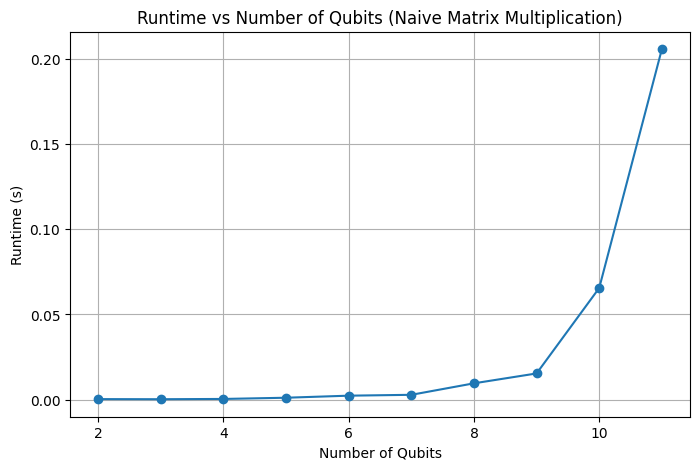

In [22]:
qubit_counts = range(2, 12)  # Adjust the range as needed
runtimes = []

for n in qubit_counts:
    start_time = time.time()
    simulate_circuit(n)
    end_time = time.time()
    runtimes.append(end_time - start_time)

# Plot the runtime
plt.figure(figsize=(8, 5))
plt.plot(qubit_counts, runtimes, marker='o')
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.title('Runtime vs Number of Qubits (Naive Matrix Multiplication)')
plt.grid(True)
plt.show()


# Advanced Simulation Using Tensor Multiplication

Instead of representing the quantum state as a single vector, we represent it as an n-dimensional tensor. This approach makes it easier to manipulate individual qubits directly, especially for larger systems.

### Key Concepts
- **Tensor Representation**: An n-qubit quantum state can be represented by a tensor of shape (2, 2, ..., 2) with n dimensions.
- **Tensor Multiplication**: Using tensor operations allows us to apply gates directly along specific qubit axes, providing a more scalable way to handle multi-qubit systems.

### Objective
1. Define the quantum state as an n-dimensional tensor.
2. Apply gates using tensor-based operations to efficiently evolve the quantum state.
3. Compare the runtime of this method with the naive matrix multiplication approach.


In [23]:
# Initialize the Quantum State Tensor

def initialize_state_tensor(n_qubits):
    # Start with single |0> state tensor
    state = np.array([1, 0], dtype=complex)
    state = state.reshape([2] + [1]*(n_qubits - 1))
    for _ in range(n_qubits - 1):
        state = np.tensordot(state, [1, 0], axes=0)
    state = state.reshape([2]*n_qubits)
    return state


## Applying Gates with Tensor Operations

Using functions like `np.tensordot` and `np.einsum`, we apply single- and two-qubit gates directly on the n-dimensional tensor. This method helps reduce the complexity of handling large statevectors.




In [24]:
# Apply Gates Using Tensor Multiplication

# Single-Qubit Gate Application
def apply_single_qubit_gate_tensor(state, gate, target_qubit):
    axes = ([target_qubit], [0])
    state = np.tensordot(state, gate, axes=axes)
    # Move the new axis to the target qubit position
    order = list(range(state.ndim))
    order.insert(target_qubit, order.pop())
    state = state.transpose(order)
    return state


In [25]:
# Two-Qubit Gate Application
# For a two-qubit gate like CNOT, we need to reshape and apply it to the correct axes.

def apply_two_qubit_gate_tensor(state, gate, qubit1, qubit2):
    # Ensure qubit1 < qubit2
    if qubit1 > qubit2:
        qubit1, qubit2 = qubit2, qubit1
    axes = ([qubit1, qubit2], [0, 1])
    state = np.tensordot(state, gate, axes=axes)
    # Move the new axes to the qubit positions
    order = list(range(state.ndim))
    new_axes = [state.ndim - 2, state.ndim - 1]
    for idx, qubit in zip(new_axes, [qubit1, qubit2]):
        order.insert(qubit, order.pop(idx))
    state = state.transpose(order)
    return state



In [26]:
# Simulate the Circuit

def simulate_circuit_tensor(n_qubits):
    state = initialize_state_tensor(n_qubits)

    # Define gates
    # Reshape gates for tensor operations
    H_gate = H.reshape(2, 2)
    X_gate = X.reshape(2, 2)
    CNOT_gate = get_two_qubit_cnot_tensor()

    # Apply gates
    state = apply_single_qubit_gate_tensor(state, H_gate, target_qubit=0)
    state = apply_single_qubit_gate_tensor(state, X_gate, target_qubit=1)
    state = apply_two_qubit_gate_tensor(state, CNOT_gate, qubit1=0, qubit2=1)

    return state



#Runtime Analysis for Tensor Simulation

To understand the efficiency of tensor multiplication in quantum state evolution, we measure the runtime as a function of the number of qubits.

Objective: Plot the runtime and analyze how scaling the number of qubits affects performance. This analysis helps determine the computational limits of the tensor simulation approach.

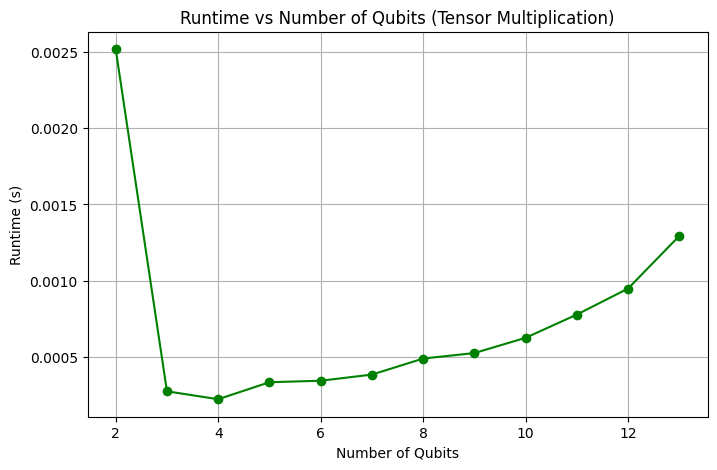

In [27]:

# Measure Runtime
import time
qubit_counts = range(2, 14)  # Adjust the range as needed
runtimes = []

for n in qubit_counts:
    start_time = time.time()
    simulate_circuit_tensor(n)
    end_time = time.time()
    runtimes.append(end_time - start_time)

# Plot the runtime
plt.figure(figsize=(8, 5))
plt.plot(qubit_counts, runtimes, marker='o', color='green')
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.title('Runtime vs Number of Qubits (Tensor Multiplication)')
plt.grid(True)
plt.show()



# Performance Analysis

## Comparison of Naive and Tensor-Based Simulations

After implementing both approaches, we compare the results and the runtime performance.

### Observations
1. **Accuracy**: Both methods yield the same quantum state for the same circuit, validating the tensor-based method.
2. **Runtime**: Tensor operations improve scalability and enable us to simulate circuits with more qubits than the naive approach.

The runtime plot below shows the comparative efficiency of each method as the number of qubits increases.


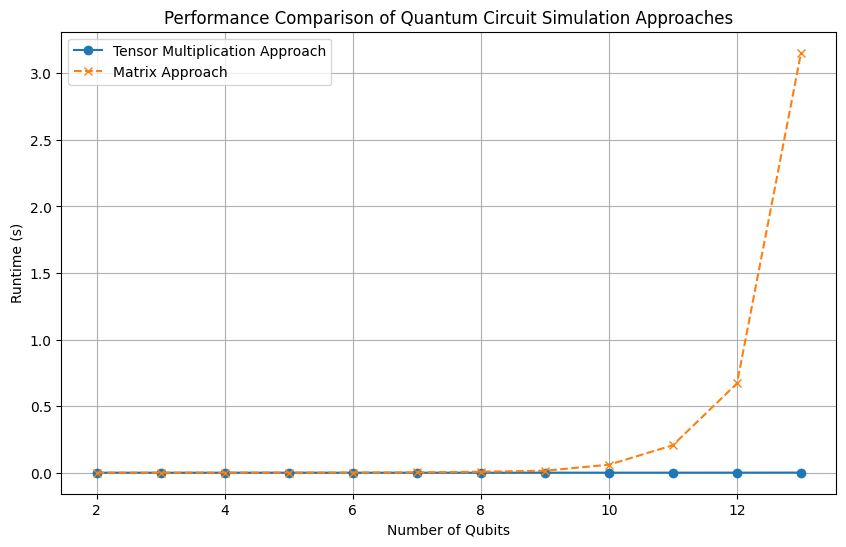

In [28]:
import time
import matplotlib.pyplot as plt

# Define the range of qubits to test
qubit_counts = range(2, 14)  # Adjust the range as needed

# Measure runtime of the original simulation function
runtimes_tensor = []
for n in qubit_counts:
    start_time = time.time()
    simulate_circuit_tensor(n)
    end_time = time.time()
    runtimes_tensor.append(end_time - start_time)

# Measure runtime of the matrix simulation function
runtimes_matrix = []
for n in qubit_counts:
    start_time = time.time()
    simulate_circuit(n)  # Replace with the alternative function's name
    end_time = time.time()
    runtimes_matrix.append(end_time - start_time)

# Plotting the performance comparison
plt.figure(figsize=(10, 6))
plt.plot(qubit_counts, runtimes_tensor, marker='o', linestyle='-', label="Tensor Multiplication Approach")
plt.plot(qubit_counts, runtimes_matrix, marker='x', linestyle='--', label="Matrix Approach")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.title('Performance Comparison of Quantum Circuit Simulation Approaches')
plt.legend()
plt.grid(True)
plt.show()


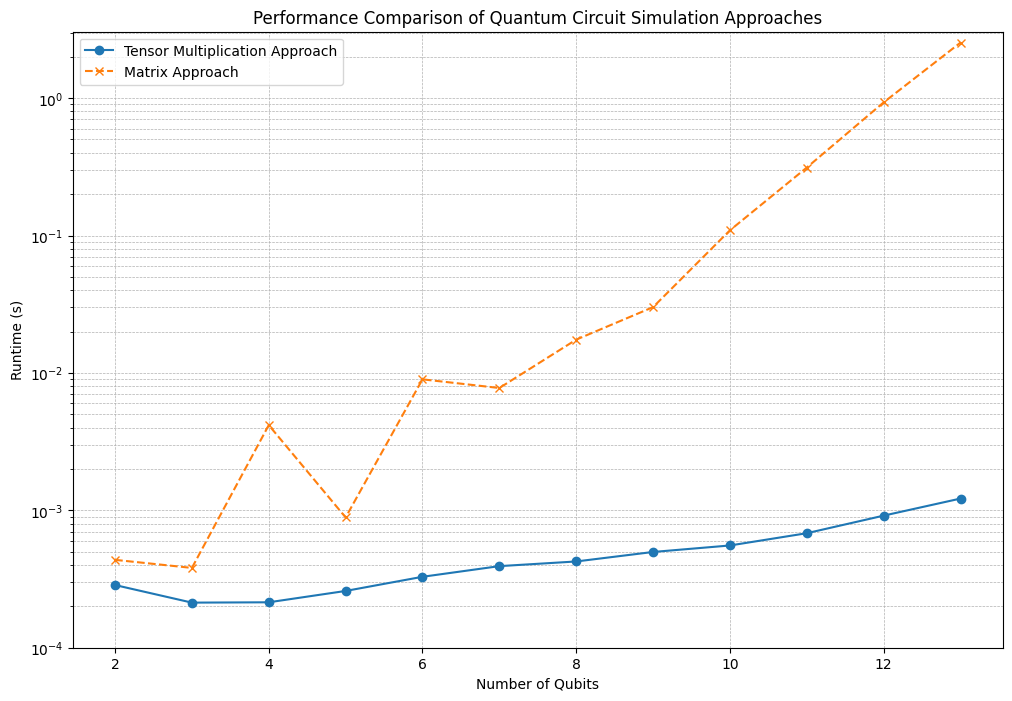

In [29]:
import time
import matplotlib.pyplot as plt

# Define the range of qubits to test
qubit_counts = range(2, 14)  # Adjust the range as needed

# Measure runtime of the original simulation function
runtimes_tensor = []
for n in qubit_counts:
    start_time = time.time()
    simulate_circuit_tensor(n)
    end_time = time.time()
    runtimes_tensor.append(end_time - start_time)

# Measure runtime of the matrix simulation function
runtimes_matrix = []
for n in qubit_counts:
    start_time = time.time()
    simulate_circuit(n)  # Replace with the alternative function's name
    end_time = time.time()
    runtimes_matrix.append(end_time - start_time)



# Plotting the performance comparison
plt.figure(figsize=(12, 8))
plt.plot(qubit_counts, runtimes_tensor, marker='o', linestyle='-', label="Tensor Multiplication Approach")
plt.plot(qubit_counts, runtimes_matrix, marker='x', linestyle='--', label="Matrix Approach")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.yscale('log')  # Set y-axis to a logarithmic scale for finer detail
plt.ylim(1e-4, max(runtimes_matrix) * 1.2)  # Adjust y-axis limit to a minimum value for clarity
plt.title('Performance Comparison of Quantum Circuit Simulation Approaches')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # Add minor grid lines for better readability
plt.show()


# Bonus Section: Sampling and Expectation Values

In this section, we explore additional features:
1. **Sampling Final State**: We can simulate measurements by probabilistically sampling from the statevector's squared amplitudes.
2. **Expectation Values**: For an operator \( O \), the expectation value in state \( |Ψ⟩ \) can be computed as ⟨Ψ| O |Ψ⟩.

These functionalities extend the simulator to provide insights similar to what would be obtained on a real quantum device.


**Sampling of Final States**

In [59]:
def sample_measurements(state, num_samples=1000):
    # Flatten the state to a vector
    state_vector = state.flatten()
    # Compute probabilities
    probabilities = np.abs(state_vector) ** 2
    # Generate possible outcomes
    outcomes = np.arange(len(state_vector))
    # Sample outcomes based on probabilities
    samples = np.random.choice(outcomes, size=num_samples, p=probabilities)
    return samples

# Example usage
state = simulate_circuit_tensor(n_qubits=5)
samples = sample_measurements(state, num_samples=1000)
#Convert outcomes to bitstrings
bitstrings = [format(sample, '03b') for sample in samples]
print(f"Sampled bitstrings: {bitstrings[:10]}")


Sampled bitstrings: ['1000', '10000', '10000', '10000', '10000', '10000', '10000', '10000', '10000', '10000']


In [67]:
def compute_expectation_value(state, operator, target_qubit):
    """
    Compute the expectation value <Psi|Op|Psi> for a single-qubit operator.

    """
    # Apply operator to the target qubit
    state_op = apply_single_qubit_gate_tensor(state, operator.reshape(2, 2), target_qubit)
    # Compute the inner product <Psi|Op|Psi>
    state_conj = np.conj(state)
    expectation = np.tensordot(state_conj, state_op, axes=state.ndim)
    return expectation



#Example Usage

n_qubits = 10
state = simulate_circuit_tensor(n_qubits)
Z = np.array([[1, 0],
              [0, -1]], dtype=complex)
expectation = compute_expectation_value(state, Z, target_qubit=0)
print(f"Expectation value of Z on qubit 0: {expectation}")



Expectation value of Z on qubit 0: (-2.2371143170757382e-17+0j)


# Summary and Final Analysis

### Comparison of Naive Matrix Multiplication and Tensor-Based Operations

- **Naive Matrix Multiplication**: This approach scales poorly with the number of qubits due to its exponential complexity \( O(2^{2n}) \). It quickly becomes infeasible for larger systems (beyond 12-14 qubits) as computation time and memory requirements grow exponentially.
- **Tensor-Based Operations**: Tensor operations allow for a more efficient way to apply gates to individual qubits or pairs of qubits within the system. The improved scalability of this approach means it can handle larger systems (up to 20 qubits or more, depending on hardware) with a relatively lower increase in computation time. (On my system I was able to 17 qubits before it crashes.)

### Runtime Plot Analysis

The runtime plot illustrates a steep, exponential increase in computation time for naive matrix multiplication, while the tensor-based approach grows more slowly, highlighting its better scalability. for larger systems.

### Practical Takeaways

- For small systems (up to ~5 qubits), both methods perform similarly and can be used effectively.
- For larger systems, **tensor-based operations** are essential due to the exponential complexity of matrix multiplication.
- Despite improvements from tensor-based methods, both approaches face exponential growth, reflecting the inherent difficulty of simulating large quantum systems on classical hardware.

### Conclusion

In summary, while **naive matrix multiplication** is useful for small-scale quantum simulations, **tensor-based operations** offer the efficiency needed for larger systems. This study emphasizes the limitations of classical simulation for large quantum circuits, underscoring the need for specialized quantum hardware to efficiently simulate complex quantum systems.
